# Deep Petro

## Preâmbulo

O código abaixo consiste dos imports comuns. Além do mais, configuramos as imagens para ficar de um tamanho aceitável e criamos algumas funções auxiliares. No geral, você pode ignorar a próxima célula.

In [1]:
pip install mxnet-cu100==1.4.1

In [0]:
# -*- coding: utf8

import matplotlib.pyplot as plt

import mxnet as mx
import mxnet.ndarray as nd

import numpy as np

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [0]:
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

Para testar o resultado dos seus algoritmos vamos usar o módulo testing do numpy.

In [0]:
from numpy.testing import assert_equal
from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal

## Aula 02 - Regressão Linear e Logística from Scratch

Um fator importante de salientar é que embora nosso curso está fazendo uso de mxnet nas aulas iniciais, vamos migrar para outros frameworks estilo PyTorch ao longo das aulas. No fim, todos são bem parecidos e aplicam as mesmas ideias de diferenciação automática. Para brincar um pouco mais com essa diferenciação, nesta aula vamos implementar a regressão linear e logística do zero. Vamos fazer duas versões de cada:

1. Derivando na mão, não é complicado.
2. Derivando com mxnet

## Conjunto de Problemas 1: Mais Derivadas

Antes de entrar na regressão, vamos brincar um pouco de derivadas dentro de funções. Dado dois números `x` and `y`, implemente a função `log_exp` que retorna:

$$-\log\left(\frac{e^x}{e^x+e^y}\right)$$

In [0]:
def log_exp(x, y):
    return(-nd.log(nd.exp(x)/(nd.exp(x) + nd.exp(y))))

1. Abaixo vamos testar o seu código com algumas entradas simples.

In [6]:
x, y = nd.array([2]), nd.array([3])
z = log_exp(x, y)
z


[1.3132617]
<NDArray 1 @cpu(0)>

In [0]:
# Teste. Não apague
assert_equal(1.31326175, z.asnumpy())

2. Agora implementa uma função para computar $\partial z/\partial x$ e $\partial z/\partial y$ usando `autograd`.

In [0]:
# O argumento funcao_forward é uma função python. Será a sua log_exp.
# A ideia aqui é deixar claro a ideia de forward e backward propagation, depois
# de avaliar a função chamamos backward e temos as derivadas.
def grad(funcao_forward, x, y):
    x.attach_grad()
    with mx.autograd.record():
      u = funcao_forward(x, y)
      u.detach()
      y.attach_grad()
      v = funcao_forward(x, y)
    
    u.backward()
    v.backward()
    return(x.grad, y.grad)

Testando

In [0]:
x, y = nd.array([2]), nd.array([3])
dx, dy = grad(log_exp, x, y)

In [0]:
assert_equal(-0.7310586, dx.asnumpy())
assert_equal(0.7310586, dy.asnumpy())

4. Agora teste com números maiores, algum problema?

In [11]:
x, y = nd.array([50]), nd.array([100])
grad(log_exp, x, y)

(
 [nan]
 <NDArray 1 @cpu(0)>, 
 [nan]
 <NDArray 1 @cpu(0)>)

5. Pense um pouco sobre o motivo do erro acima. Usando as propriedade de logaritmos, é possível fazer uma função mais estável? Implemente a mesma abaixo. O problema aqui é que o exponencial "explode" quando x ou y são muito grandes. Use o [link](http://www.wolframalpha.com/input/?i=log[e%5Ex+%2F+[e%5Ex+%2B+e%5Ey]]) para lhe ajudar.

In [0]:
def stable_log_exp(x, y):
    return(nd.log(1+nd.exp(y-x)))

dx, dy = grad(stable_log_exp, x, y)

In [13]:
stable_log_exp(x, y)


[50.]
<NDArray 1 @cpu(0)>

In [0]:
# Teste. Não apague
assert_equal(-1, dx.asnumpy())
assert_equal(1, dy.asnumpy())

O exemplo acima mostra um pouco de problemas de estabilidade númerica. às vezes é melhor usar versões alternativas de funções. Isto vai ocorrer quando você ver vários nans na sua frente :-) Claro, estamos assumindo que existe uma outra função equivalente que é mais estável para o computador.

## Conjunto de Problemas 2: Regressão Linear

Agora, vamos explorar uma regressão linear. Embora não vamos fazer uso da logexp acima, a ideia de derivar parcialmente dentro de funções pode nos ajudar. Lembrando da regressão linear, inicialmente temos um conjunto observações representadas como tuplas $(\mathbf{x}_i, y_i)$. Aqui, $\mathbf{x}_i$ é um vetor de atributos. Vamo forçar $\mathbf{x}_{i0} = 1$, capturando assim o intercepto. Além do mais, $\mathbf{x}_{ij}$ quando $j\neq 0$, são os outros atributos de entrada. $y_i$ uma valor real representando uma resposta. Nossa regressão visa capturar:

$$y_i = 1 + \theta_1 x_{i1} + \theta_2 x_{i2} + \cdots + \theta_k x_{if}$$

Lembrando da regressão linear multivariada, podemos representar as equações como uma multiplicação de uma matriz com um vetor

![](https://github.com/deep-petro/praticas/blob/master/01-Semana/figs/linear.png?raw=1)

7. Crie uma função de previsao. A mesma recebe uma matrix $\mathbf{X}$ e um vetor de parâmetros $\theta$. Sua função deve retornar um vetor de previsões para cada linha de $\mathbf{X}$. Não use nenhum laço!!

In [0]:
def previsao(X, theta):
    return(nd.dot(X, theta))

**Erros quadrados**. Para aprender os parâmetros ótimos da regressão linear, precisamos fazer uso de um modelo de erros quadrados. Em particular nosso objetico é aprender os parâmetros que minimizam a função:

$$L(\mathbf{\theta}) = n^{-1} \sum_i ({\hat{y}_i - y_i})^2$$

Onde $\hat{y}_i$ é uma previsão (vêm da sua função python acima). $y_i$ é o valor real dos dados.

8. Implemente uma função para a média dos os erros quadrados.

In [0]:
def media_erros_quadrados(X, theta, y):
    n = X.shape[0]
    y_hat = previsao(X, theta)
    return(nd.sum(nd.power(y_hat - y, 2))/n)

9. Agora, crie **DUAS** funções que derivam o erro acima. A primeira deve usar o autograd de mxnet. Lembre-se que temos um vetor de parâmetros $\theta$. Por sorte, você pode fazer derivadas de tais vetores também.

In [0]:
def derivada_mxnet(X, theta, y):
    theta.attach_grad()
    with mx.autograd.record():
      e = media_erros_quadrados(X, theta, y)
      
    e.backward()
    return(theta.grad)

10. A segunda versão não usa mxnet. Implemente as derivadas do zero. Nos [slides](https://docs.google.com/presentation/d/1bz3G3fEohNtvERKSDtThfGPYOjF83Fzy2yHPdCAlFZw/edit#slide=id.g584f66d2ae_3_74) do link explicamos como fazer tal operação.

In [0]:
def derivada_navera(X, theta, y):
  n = X.shape[0]
  y_hat = previsao(X, theta)
  erro = (y - y_hat).reshape(n, 1)
  dtheta = (-2*nd.dot(erro.T, X)/n)[0]
  return(dtheta)

11. Por fim, otimize sua função usando o algoritmo de gradiente descendente abaixo.

In [0]:
def gd(d_fun, loss_fun, X, y, lambda_=0.01, tol=0.00001, max_iter=10000):
    '''
    Executa Gradiente Descendente. Aqui:
    
    Parâmetros
    ----------
    d_fun : é uma função de derivadas
    loss_fun : é uma função de perda
    X : é um vetor de fatores explanatórios.
        Copie seu código de intercepto da primeira aula.
        para adicionar o intercepto em X.
    y : é a resposta
    lambda : é a taxa de aprendizad
    tol : é a tolerância, define quando o algoritmo vai parar.
    max_ter : é a segunda forma de parada, mesmo sem convergir
              paramos depois de max_iter iterações.
    '''
    theta = nd.random.normal(shape=X.shape[1])
    print('Iter {}; theta = '.format(0), theta)
    old_err_sq = np.inf
    i = 0
    while True:
        # Computar as derivadas
        grad = d_fun(X, theta, y)
        # Atualizar
        theta_novo = theta - lambda_ * grad
        
        # Parar quando o erro convergir
        err_sq = loss_fun(X, theta, y)
        if nd.abs(old_err_sq - err_sq) <= tol:
            break
        
        # Atualizar parâmetros e erro
        theta = theta_novo
        old_err_sq = err_sq
        
        # Informação de debug
        print('Iter {}; theta = '.format(i+1), theta)
        i += 1
        if i == max_iter:
            break
    return theta

In [0]:
# Para testes, não apague!!!
X = nd.zeros(shape=(1000, 2))
X[:, 0] = 1
X[:, 1] = nd.random.normal(shape=1000)

theta_0_real = 7
theta_1_real = 9
y = theta_0_real + theta_1_real * X[:, 1]

In [21]:
# Sua função deve retornar algo perto de 7 e 9
theta = gd(derivada_mxnet, media_erros_quadrados, X, y)

Iter 0; theta =  
[0.7787424 0.6087823]
<NDArray 2 @cpu(0)>
Iter 1; theta =  
[0.90454584 0.79576254]
<NDArray 2 @cpu(0)>
Iter 2; theta =  
[1.0278026 0.9785785]
<NDArray 2 @cpu(0)>
Iter 3; theta =  
[1.1485641 1.1573228]
<NDArray 2 @cpu(0)>
Iter 4; theta =  
[1.266881  1.3320861]
<NDArray 2 @cpu(0)>
Iter 5; theta =  
[1.3828028 1.5029571]
<NDArray 2 @cpu(0)>
Iter 6; theta =  
[1.4963783 1.6700222]
<NDArray 2 @cpu(0)>
Iter 7; theta =  
[1.6076548 1.8333664]
<NDArray 2 @cpu(0)>
Iter 8; theta =  
[1.7166789 1.9930725]
<NDArray 2 @cpu(0)>
Iter 9; theta =  
[1.8234962 2.1492214]
<NDArray 2 @cpu(0)>
Iter 10; theta =  
[1.9281516 2.3018923]
<NDArray 2 @cpu(0)>
Iter 11; theta =  
[2.0306888 2.4511628]
<NDArray 2 @cpu(0)>
Iter 12; theta =  
[2.1311507 2.5971084]
<NDArray 2 @cpu(0)>
Iter 13; theta =  
[2.2295794 2.739803 ]
<NDArray 2 @cpu(0)>
Iter 14; theta =  
[2.3260162 2.8793194]
<NDArray 2 @cpu(0)>
Iter 15; theta =  
[2.4205012 3.015728 ]
<NDArray 2 @cpu(0)>
Iter 16; theta =  
[2.5130742 3.

In [22]:
theta


[6.9877796 8.991643 ]
<NDArray 2 @cpu(0)>

In [23]:
# Sua função deve retornar algo perto de 7 e 9
theta = gd(derivada_navera, media_erros_quadrados, X, y)

Iter 0; theta =  
[1.0741756  0.06642842]
<NDArray 2 @cpu(0)>
Iter 1; theta =  
[1.1941595 0.2653794]
<NDArray 2 @cpu(0)>
Iter 2; theta =  
[1.3117111  0.45990166]
<NDArray 2 @cpu(0)>
Iter 3; theta =  
[1.4268796 0.6500938]
<NDArray 2 @cpu(0)>
Iter 4; theta =  
[1.5397136 0.8360522]
<NDArray 2 @cpu(0)>
Iter 5; theta =  
[1.6502603 1.0178709]
<NDArray 2 @cpu(0)>
Iter 6; theta =  
[1.7585663 1.1956422]
<NDArray 2 @cpu(0)>
Iter 7; theta =  
[1.8646768 1.3694562]
<NDArray 2 @cpu(0)>
Iter 8; theta =  
[1.9686366 1.5394008]
<NDArray 2 @cpu(0)>
Iter 9; theta =  
[2.0704894 1.7055622]
<NDArray 2 @cpu(0)>
Iter 10; theta =  
[2.1702778 1.8680246]
<NDArray 2 @cpu(0)>
Iter 11; theta =  
[2.2680438 2.02687  ]
<NDArray 2 @cpu(0)>
Iter 12; theta =  
[2.3638282 2.1821795]
<NDArray 2 @cpu(0)>
Iter 13; theta =  
[2.4576714 2.3340313]
<NDArray 2 @cpu(0)>
Iter 14; theta =  
[2.549613  2.4825025]
<NDArray 2 @cpu(0)>
Iter 15; theta =  
[2.6396914 2.6276684]
<NDArray 2 @cpu(0)>
Iter 16; theta =  
[2.7279441 

In [24]:
theta


[6.988433 8.991049]
<NDArray 2 @cpu(0)>

12. Altere a função de Gradiente Descendente para funcionar com minibatches. Em outras palavras, não compute o erro usando todos os dados de X. Use um `slice` de tamanho do minibatch. Uma ideia é seguir o pseudocódigo abaixo.

```python
index = np.arange(len(X))
while True:
    minib = np.random.choice(index, minibatchsize) # aqui estou usando numpy para selection minibatch elementos
    X_batch = X[minib]
```

In [25]:
# Exemplo abaixo
index = np.arange(len(X))
mb = np.random.choice(index, 50)
print(mb)
X[mb]

[388 428 658 652 939  46 906 965 542 184 940 841 307 956 559 312 499  82
 947 840 486 476 315 945 510 580 106 865 940 121 463 252 718 899 698 222
 172 599 763 851   5 135 568 765 494 925 896 971 699 762]



[[ 1.         -1.1489    ]
 [ 1.          0.19221152]
 [ 1.          0.6158901 ]
 [ 1.         -1.4778582 ]
 [ 1.         -1.4649591 ]
 [ 1.         -0.52853745]
 [ 1.         -0.31461143]
 [ 1.         -2.095032  ]
 [ 1.         -1.55687   ]
 [ 1.          0.5808451 ]
 [ 1.          1.7879504 ]
 [ 1.          0.16363572]
 [ 1.         -0.9446958 ]
 [ 1.         -0.3311225 ]
 [ 1.          1.4283854 ]
 [ 1.         -1.3725436 ]
 [ 1.          2.0810165 ]
 [ 1.          0.3553293 ]
 [ 1.          1.106874  ]
 [ 1.         -0.51666147]
 [ 1.         -1.6963103 ]
 [ 1.         -1.2779027 ]
 [ 1.          0.09964364]
 [ 1.          0.33800116]
 [ 1.          0.7936089 ]
 [ 1.          2.0719576 ]
 [ 1.          0.07959834]
 [ 1.         -1.7015792 ]
 [ 1.          1.7879504 ]
 [ 1.          0.71950465]
 [ 1.         -1.0454986 ]
 [ 1.         -1.2727575 ]
 [ 1.         -0.19343433]
 [ 1.          0.39740315]
 [ 1.          0.92883945]
 [ 1.          1.6517719 ]
 [ 1.          0.05124917]


In [0]:
def minibatch_gd(d_fun, loss_fun, X, y, lambda_=0.01, tol=0.00001,
                 max_iter=10000, batch_size=10):
    '''
    Executa Gradiente Descendente. Aqui:
    
    Parâmetros
    ----------
    d_fun : é uma função de derivadas
    loss_fun : é uma função de perda
    X : é um vetor de fatores explanatórios.
        Copie seu código de intercepto da primeira aula.
        para adicionar o intercepto em X.
    y : é a resposta
    lambda : é a taxa de aprendizad
    tol : é a tolerância, define quando o algoritmo vai parar.
    max_ter : é a segunda forma de parada, mesmo sem convergir
              paramos depois de max_iter iterações.
    batch_size : tamanho do batch
    '''
    
    
    
    index = np.arange(len(X))
    theta = nd.random.normal(shape=X.shape[1])
    print('Iter {}; theta = '.format(0), theta)
    old_err_sq = np.inf
    i = 0
    while True:
        # Mini batch
        mb = np.random.choice(index, batch_size)
        # Computar as derivadas
        grad = d_fun(X[mb], theta, y[mb])
        # Atualizar
        theta_novo = theta - lambda_ * grad
        
        # Parar quando o erro convergir
        err_sq = loss_fun(X[mb], theta, y[mb])
        if nd.abs(old_err_sq - err_sq) <= tol:
            break
        
        # Atualizar parâmetros e erro
        theta = theta_novo
        old_err_sq = err_sq
        
        # Informação de debug
        print('Iter {}; theta = '.format(i+1), theta)
        i += 1
        if i == max_iter:
            break
    return theta

In [27]:
# Sua função deve retornar algo perto de 7 e 9
minibatch_gd(derivada_mxnet, media_erros_quadrados, X, y)

Iter 0; theta =  
[ 0.8486986 -0.8003802]
<NDArray 2 @cpu(0)>
Iter 1; theta =  
[ 0.95912385 -0.6333051 ]
<NDArray 2 @cpu(0)>
Iter 2; theta =  
[ 1.036329 -0.567187]
<NDArray 2 @cpu(0)>
Iter 3; theta =  
[ 1.1025481  -0.32803667]
<NDArray 2 @cpu(0)>
Iter 4; theta =  
[ 1.2219893  -0.07383889]
<NDArray 2 @cpu(0)>
Iter 5; theta =  
[1.4303472  0.25129774]
<NDArray 2 @cpu(0)>
Iter 6; theta =  
[1.6077173 0.4866404]
<NDArray 2 @cpu(0)>
Iter 7; theta =  
[1.7060882 0.7112972]
<NDArray 2 @cpu(0)>
Iter 8; theta =  
[1.8486302  0.91925216]
<NDArray 2 @cpu(0)>
Iter 9; theta =  
[1.8480021 1.1033206]
<NDArray 2 @cpu(0)>
Iter 10; theta =  
[1.9480093 1.2662314]
<NDArray 2 @cpu(0)>
Iter 11; theta =  
[1.9671828 1.3885956]
<NDArray 2 @cpu(0)>
Iter 12; theta =  
[2.0035582 1.5313721]
<NDArray 2 @cpu(0)>
Iter 13; theta =  
[2.124237  1.6590799]
<NDArray 2 @cpu(0)>
Iter 14; theta =  
[2.22003   1.7493024]
<NDArray 2 @cpu(0)>
Iter 15; theta =  
[2.3459024 1.931114 ]
<NDArray 2 @cpu(0)>
Iter 16; theta =


[6.97241  8.976725]
<NDArray 2 @cpu(0)>

## Conjunto de Problemas 3: Logistic from Scratch

12. Repita o mesmo processo para a Logística. Lembrando que a mesma tem a seguinte forma:

$$f(x_i) = \frac{1}{1 + e^{-(1 + \theta_1 x_{i1} + \theta_2 x_{i2} + \cdots \theta_k x_{ik})}}$$

Implemente a função logística.

In [0]:
def logistic(X, theta):
    return( 1/(1+nd.exp(-nd.dot(X, theta))) )

In [0]:
# testes, não apague!
X_teste = nd.random.normal(shape=(1000, 20000))
theta = nd.random.normal(shape=(20000))
y_hat_teste = logistic(X_teste, theta)
assert_equal(True, (y_hat_teste >= 0).asnumpy().all())
assert_equal(True, (y_hat_teste <= 1).asnumpy().all())

Usando a logística acima implemente uma função logistica_prever que retorna 0 ou 1. Use o limar dado na função. 

In [0]:
def logistica_prever(X, theta, limiar=0.5):
    return(logistic(X, theta) >= limiar)

In [0]:
# testes, não apague!
X_teste = nd.random.normal(shape=(1000, 20000))
theta = nd.random.normal(shape=(20000))
y_hat_teste = logistica_prever(X_teste, theta)
for yi in y_hat_teste.asnumpy():
    assert(yi in {0, 1})

Agora, implemente uma função de entropia cruzada da logística. A mesma, é proporcional ao inverso da verossimilhança. Para entender a derivação entre as duas faça uso dos [Slides](https://docs.google.com/presentation/d/1yGPETPe8o7PPOP6_CF38LHr3vpxgTEnF5LjP-1pkGIc/edit?usp=sharing). 

Sendo:

$$ll(x_i,y_i~|~\theta) = y_i \log f(x_i\theta) + (1-y_i) \log (1-f(x_i\theta))$$

A verossimilhança para uma observação. A entropia cruzada é a media da negação do termo para todos os exemplos:

$$L(\theta) = -n^{-1}\sum_i \big((1-y_i)\log (1-f_{\theta}(x_i)) + y_i\log (f_{\theta}(x_i))\big)$$

`dica: use nd.clip(logistic(X, theta), 0.001, 0.999)`. A função remove os 0 e 1s da logistic, evitando assim o valor log(0).

In [0]:
def cross_entropy_mean(X, theta, y):
    
    n = X.shape[0]
    logit_clipped = nd.clip(logistic(X, theta), 0.001, 0.999)
    second_term = nd.dot(nd.log(logit_clipped), y)
    first_term = nd.dot(nd.log(1-logit_clipped), 1-y)
    
    return( -(first_term + second_term)/n )

In [0]:
# testes, não apague!
from sklearn import datasets
state = np.random.seed(20190187)

X, y = datasets.make_blobs(n_samples=200, n_features=2, centers=2)
X = nd.array(X)
y = nd.array(y)

for _ in range(100):
    theta = nd.random.normal(shape=(2, ))
    assert(cross_entropy_mean(X, theta, y) >= 0)

Agora implemente a derivada.

In [0]:
def derivada_mxnet_logit(X, theta, y):
    theta.attach_grad()
    with mx.autograd.record():
      u = logistic(X, theta)
      
    u.backward()
    
    return(theta.grad)

A partir daqui basta executar código.

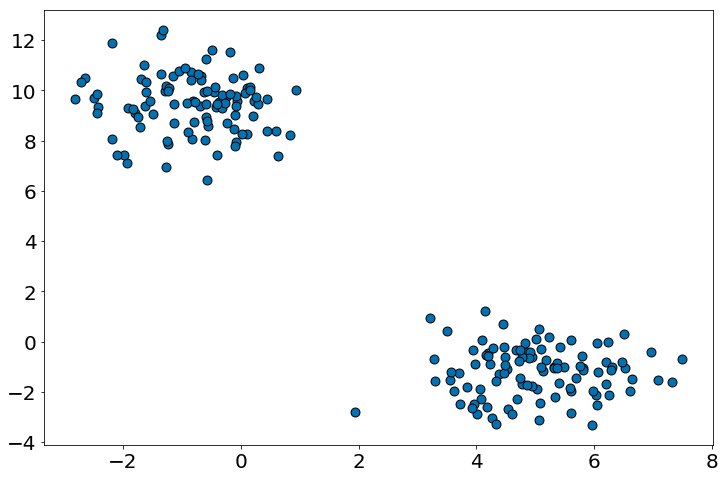

In [35]:
plt.scatter(X.asnumpy()[:, 0], X.asnumpy()[:, 1], s=80, edgecolors='k')

13. Assim como foi feito na primeira aula, abaixo testamos o seu código com um toy dataset.

In [0]:
# Use essa função antes de executar o GD
def add_intercept(X):
    Xn = nd.zeros(shape=(X.shape[0], X.shape[1] + 1))
    Xn[:, 0]  = 1
    Xn[:, 1:] = X
    return Xn

In [46]:
Xn = add_intercept(X)
theta = minibatch_gd(derivada_mxnet_logit, cross_entropy_mean, Xn, y)

Iter 0; theta =  
[-0.3837021   0.63991284  1.0479566 ]
<NDArray 3 @cpu(0)>
Iter 1; theta =  
[-0.38886744  0.6141917   1.0548044 ]
<NDArray 3 @cpu(0)>
Iter 2; theta =  
[-0.39881092  0.565284    1.0733968 ]
<NDArray 3 @cpu(0)>
Iter 3; theta =  
[-0.40813532  0.5230396   1.083314  ]
<NDArray 3 @cpu(0)>
Iter 4; theta =  
[-0.4165826  0.4731783  1.0959677]
<NDArray 3 @cpu(0)>
Iter 5; theta =  
[-0.4230716   0.43889433  1.1104151 ]
<NDArray 3 @cpu(0)>
Iter 6; theta =  
[-0.43407103  0.38574344  1.1264422 ]
<NDArray 3 @cpu(0)>
Iter 7; theta =  
[-0.44422084  0.33678848  1.138571  ]
<NDArray 3 @cpu(0)>
Iter 8; theta =  
[-0.45313844  0.29896247  1.1508856 ]
<NDArray 3 @cpu(0)>
Iter 9; theta =  
[-0.46830475  0.22609419  1.1594453 ]
<NDArray 3 @cpu(0)>
Iter 10; theta =  
[-0.4830044   0.15654603  1.1689343 ]
<NDArray 3 @cpu(0)>
Iter 11; theta =  
[-0.49236023  0.10920915  1.1747975 ]
<NDArray 3 @cpu(0)>
Iter 12; theta =  
[-0.5021179   0.05910057  1.1810311 ]
<NDArray 3 @cpu(0)>
Iter 13; the

In [47]:
y_p = logistica_prever(Xn, theta)
print((y == y_p).mean())


[1.]
<NDArray 1 @cpu(0)>
